## Evolution

Функция, сопоставляющая генотипу степерь его приспособленности, называется fitness landscape. Если длина генотипа равна N, то генотип можно представить как точку в N-мероном пространстве, а приспособленность (fitness) точки можно рассматривать как высота локации с этой точкой. В биологическом смысле генотип определяет набор признаков организма - фенотип.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

# make a directory for figures
!mkdir figures

from os.path import basename, exists
def download(url):
    fileName = basename(url)
    if not exists(fileName):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, fileName)
        print(f'Downloaded {local}')

download('https://github.com/wernadsky/test/raw/master/utils.py')

from utils import decorate

A subdirectory or file figures already exists.


In [2]:
class FitnessLandscape:
    """Ландшафт приспособленности - сраеда со случайно инициированным
    распределением приспособленности в N-мерном пространстве для генотипов,
    состоящих из 0 и 1 длины N
    """
    def __init__(self, N):

        self.N = N
        self.setValues()

    def setValues(self):
        """Устанавливаются два массива длины N, содержащщие случайные
        значения между 0. и 1. Эти значения определяют приспособленность
        тех или иных локаций в N-мерном пространстве генотипов
        """
        self.oneValues = np.random.random(self.N)
        self.zeroValues = np.random.random(self.N)

    def radnomLoc(self):
        """Выбор случайной локации
        returns: array of N 0s and 1s
        """
        return np.random.randint(2, size=self.N, dtype=np.int8)

    def fitness(self, loc):
        """Оценка приспособленности локации
        loc: array of N 0s and 1s
        returns: float - fitness
        """
        fs = np.where(loc, self.oneValues, self.zeroValues)
        return fs.mean()

    def distance(self, loc1, loc2):
        """Расстояние между двумя последовательностями из 0 и 1"""
        return np.sum(np.logical_xor(loc1, loc2))

In [3]:
fitLand = FitnessLandscape(3)
fitLand.oneValues, fitLand.zeroValues

(array([0.60729915, 0.63195614, 0.67527586]),
 array([0.29516497, 0.08633098, 0.89353305]))

In [4]:
loc1 = fitLand.radnomLoc()
loc2 = fitLand.radnomLoc()
print(f'{loc1 = }')
print(f'{loc2 = }')
d = fitLand.distance(loc1, loc2)
fitness1 = fitLand.fitness(loc1)
fitness2 = fitLand.fitness(loc2)
print(f'distance: {d}')
print(f'{fitness1 = }, {fitness2 = }')

loc1 = array([0, 1, 1], dtype=int8)
loc2 = array([1, 1, 1], dtype=int8)
distance: 1
fitness1 = 0.5341323219126495, fitness2 = 0.6381770511514485


In [5]:
class Agent:
    """Класс особи"""
    def __init__(self, loc, fitLand):
        self.loc = loc                          # геном особи
        self.fitLand = fitLand                  # среда обитания
        self.fitness = fitLand.fitness(loc)     # приспособленность

    def copy(self):
        return Agent(self.loc, self.fitLand)

In [6]:
loc = fitLand.radnomLoc()
agent = Agent(loc, fitLand)
agent.loc, agent.fitness

(array([0, 0, 1], dtype=int8), 0.35225726929911133)

## Симуляция без отбора

In [7]:
class Simulation:
    """Класс, содержащий среду обитания, популяцию и методы симуляции.
    В этих методах отсутствует отбор: отмирает некоторое число случайных особей,
    а им на смену приходят копии также случайных особей. Кроме того класс содержит
    список инструментов (объектов классов, наследующих класс Instruments) для
    отрисовки полезных функций
    """
    def __init__(self, fitLand, agents):
        self.fitLand = fitLand              # среда обитания
        self.agents = np.asarray(agents)    # популяция
        self.instruments = []

    def run(self, numSteps=500):
        self.updateInstruments()
        for _ in range(numSteps):
            self.step()

    def step(self):
        fits = self.getFitnesses()
        indexDead = self.chooseDead(fits)
        numDead = len(indexDead)
        replacements = self.chooseReplacements(numDead, fits)
        self.agents[indexDead] = replacements
        self.updateInstruments()

    def getLocs(self):
        return [tuple(agent.loc) for agent in self.agents]

    def getFitnesses(self):
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)

    def chooseDead(self, ps):
        n = len(self.agents)
        # случайно отбираются индексы убиваемых особей
        isDead = np.random.random(n) < 0.1
        indexDead = np.nonzero(isDead)[0]
        return indexDead

    def chooseReplacements(self, n, weights):
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

    # методы работы с инструментами
    def plot(self, index, *args, **kwargs):
        self.instruments[index].plot(*args, **kwargs)

    def addInstrument(self, instrument):
        self.instruments.append(instrument)

    def updateInstruments(self):
        for instrument in self.instruments:
            instrument.update(self)

In [8]:
def makeIdenticalAgents(fitLand, numAgents, agentMaker):
    """Создает массив идентичных агентов случайного генома
    
    fitLand: FitnessLandscape
    numAgents: int
    agentMaker: class, используемые для создания агнетов
    
    returns: numpy array of Agents
    """
    loc = fitLand.radnomLoc()
    agents = [agentMaker(loc, fitLand) for _ in range(numAgents)]
    return np.array(agents)

In [9]:
def makeRandomAgents(fitLand, numAgents, agentMaker):
    """Создает массив разнообразных агентов случайного генома
    
    fitLand: FitnessLandscape
    numAgents: int
    agentMaker: class, используемые для создания агнетов
    
    returns: numpy array of Agents
    """
    locs = [fitLand.radnomLoc() for _ in range(numAgents)]
    agents = [agentMaker(loc, fitLand) for loc in locs]
    return np.array(agents)

In [10]:
import itertools

def makeAllAgents(fitLand, agentMaker):
    """Создает массив всех возможных агентов
    
    fitLand: FitnessLandscape
    agentMaker: class, используемые для создания агнетов
    
    returns: numpy array of Agents
    """
    N = fitLand.N
    # создадим итератор, содержащий всевозможные комбинации 0 и 1 длины N: 
    locs = itertools.product([0, 1], repeat=N)
    agents = [agentMaker(loc, fitLand) for loc in locs]
    return np.array(agents)

`make_all_agents` uses `itertools.product`, which returns a generator that enumerates the Cartesian product of the set `{0, 1}` with itself `N` times, which is a fancy way to say that it enumerates all sequences of `N` bits.  Here's an example:


In [11]:
fitLand = FitnessLandscape(3)           # среда для особей с геномом длины 3
# массив всевозможных особей с геномом длины 3:
agents = makeAllAgents(fitLand, Agent)
for agent in agents:
    print(agent.loc, agent.fitness)

(0, 0, 0) 0.5438906815751295
(0, 0, 1) 0.7403326831125078
(0, 1, 0) 0.596927615933937
(0, 1, 1) 0.7933696174713152
(1, 0, 0) 0.6132505819062664
(1, 0, 1) 0.8096925834436446
(1, 1, 0) 0.6662875162650739
(1, 1, 1) 0.8627295178024522


### Распределение приспособленностей

In [12]:
N = 8
# np.random.seed(17)
fitLand = FitnessLandscape(N)
# массив всевозможных особей с геномом длины N:
agents = makeAllAgents(fitLand, Agent)
sim = Simulation(fitLand, agents)

In [13]:
from empiricaldist import Cdf

def plotFitnesses(sim):
    """Отрисовка функции распределения приспособленности как случайной величины
    """
    fits = sim.getFitnesses()
    cdfFitness = Cdf.from_seq(fits)   # объект empiricaldist.empiricaldist.Cdf
    cdfFitness.plot()
    return np.mean(fits)

Функция распределения вероятности F(x) случайной величины (CDF - cumulative distribution function) отражает вероятность того, что случайная величина примет значение, меньшее x.

No handles with labels found to put in legend.


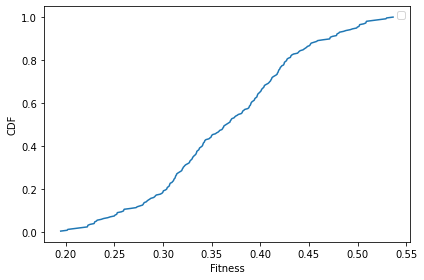

In [14]:
plotFitnesses(sim)
decorate(xlabel='Fitness', ylabel='CDF')

Изначально распределение соответствует Гауссиану, так как мы имеем 8 независимых равномерно распределенных переменных генома (256 уникальных комбинаций). А после 100 шагов количество уникальных комбинаций сокращается, что выражается в том, что функция уже не такая гладкая, так как при уменьшении числа уникальных комбинаций, сокращается так же число значений в последовательности fits. 

No handles with labels found to put in legend.


256


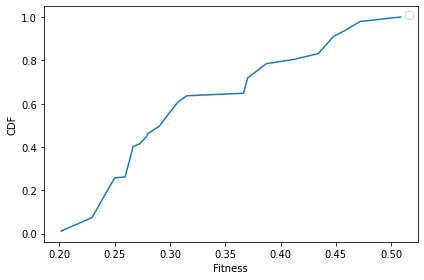

In [15]:
sim.run(100)
plotFitnesses(sim)
decorate(xlabel='Fitness', ylabel='CDF')
print(len(sim.agents))

Попробуем дальше проследить за тем, как во времени меняется среднее значение приспособленности

### Instruments

Для измерения изменений в ходе симуляции, будем импользовать объекты-инструменты

In [16]:
class Instrument:
    def __init__(self):
        self.metrics = []   # измеряемые величины

    def update(self, sim):
        """Вычисляется текущая измеряемая величина и добавляется в metrics
        sim: Simulation object
        """
        # дочерние клетки должны реализовывать этот метод
        pass

    def plot(self, **options):
        plt.plot(self.metrics, **options)

Инструмент `MeanFitness` вычисляет среднее значение приспособленности на каждой итерации `step`

In [17]:
class MeanFitness(Instrument):
    """Вычислает среднее значение приспособленности на каждой итерации"""
    label = 'Mean fitness'

    def update(self, sim):
        mean = np.nanmean(sim.getFitnesses())
        self.metrics.append(mean)

No handles with labels found to put in legend.


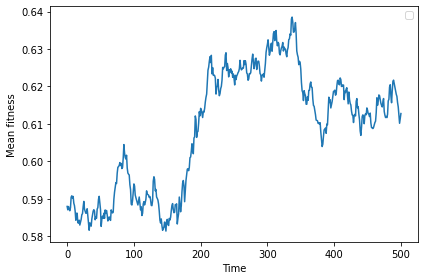

In [18]:
N = 8
fitLand = FitnessLandscape(N)
agents = makeAllAgents(fitLand, Agent)

sim = Simulation(fitLand, agents)
instrument = MeanFitness()
sim.addInstrument(instrument)
sim.run(500)
sim.plot(index=0)

decorate(xlabel='Time', ylabel='Mean fitness')

Мы можем лучше понять поведене усредненного значения приспособленности, если нарисуем графики для нескольких таких симуляций

In [19]:
def plotSims(fitLand, agentMaker, simMaker, instrumentMaker, **plotOptions):

    plotOptions['alpha'] = 0.4

    for _ in range(10):
        agents = agentMaker(fitLand)
        sim = simMaker(fitLand, agents)
        instrument = instrumentMaker()
        sim.addInstrument(instrument)
        sim.run()
        sim.plot(index=0, **plotOptions)

    decorate(xlabel='Time', ylabel=instrument.label)
    return sim

def agentMaker(fitLand):
    return makeAllAgents(fitLand, Agent)

Без отбора среднее значение приспособленности случайно блуждает:

No handles with labels found to put in legend.


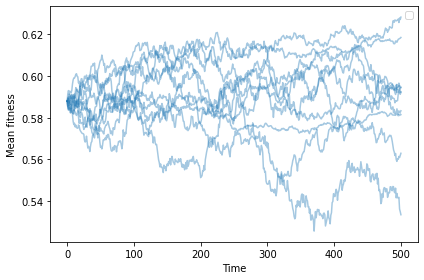

In [20]:
plotSims(fitLand, agentMaker, Simulation, MeanFitness, color='C0')

## Симуляция с отбором

In [21]:
class SimWithDiffSurvival(Simulation):
    def chooseDead(self, ps):

        n = len(self.agents)
        # убиваем особи, приспособленность которйх меньше случайной величины
        isDead = np.random.random(n) > ps
        indexDead = np.nonzero(isDead)[0]
        return indexDead

No handles with labels found to put in legend.


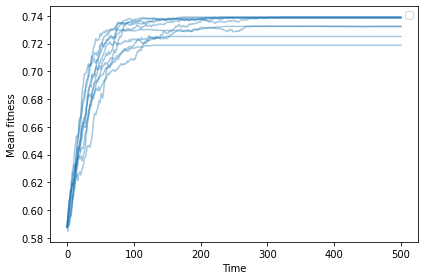

In [23]:
plotSims(fitLand, agentMaker, SimWithDiffSurvival, MeanFitness, color='C0')